# Introduction to Programming and Numerical Analysis
# Re-exam 2022 

In [53]:
from scipy import optimize
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('seaborn-whitegrid')
from types import SimpleNamespace
from copy import copy

# local module for linear algebra
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A. Maximum Simulated Likelihood

In this exercise, we will consider the logit model for a binary discrete choice. Just for exposition, our binary choice will be to study programming or not. 

The benefit of choosing to study programming is described by a linear utility index $y_i^*$. If $y_i^* > 0$ then an individual will choose to study. 

In our context, $y_i^*$ depends only on one background variable $x_i$. In addition, we will allow all individuals have their own idiosyncratic effect of $x_i$ on their study propensity. This is obtained by letting the coefficient on $x_i$ be comprised of a common effect, denoted $\beta^{1}$, and an idiosyncratic part $w_i$.  

The utility of studying also depends on a random shock, $\varepsilon$, which follows a logistic distribution. 

We write the utility index as
$$
\begin{aligned}
	y_{i}^*  =&\beta^{0} + (\beta^{1} + w_i)x_{i} + \varepsilon_i \\
    & \varepsilon_i \sim logistic(0,1) \\
	& w_i \sim \mathcal{N}(0,\sigma_{w}^{2})
\end{aligned}
$$

Note that the econometrician cannot observe the utility index. One can only observe *actual choices* which are based on the underlying index. We therefore associate the indicator variable $y_i$ with the choice taken by individual $i$

$$
\begin{aligned}
	y_i & = 1 \Leftrightarrow y^* > 0 \Leftrightarrow \text{Study programming} \\
	y_i & = 0 \Leftrightarrow y^* \le 0 \Leftrightarrow \text{Do not study programming}
\end{aligned}
$$



Because we assume that the utility shocks follow a logistic distribution, we can formulate the **probability** that an individual chooses to take the action by

$$
\begin{aligned}
	P(y_i = 1|x_i, w_i;\beta) &= \frac{\exp(\beta^{0} + (\beta^{1} + w_i)x_{i})}{1 + \exp(\beta^{0} + (\beta^{1} + w_i)x_{i})} \equiv \Lambda(\beta^{0} + (\beta^{1} + w_i)x_{i}) \\
	P(y_i = 0|x_i, w_i;\beta) &= 1 - \Lambda(\beta^{0} + (\beta^{1} + w_i)x_{i})
\end{aligned}
$$

**CHALLENGE**  
It would be easy to proceed with estimation if $w_i$ was observed, then it would just enter as data. Yet it is not, and so we need to take it into account in some other way. The standard approach is to take the **expectation** of the density of $y_i$ over $w_i$ for each individual and use this expected density for likelihood contributions.   

To this end, you can use **Monte Carlo integration**. That implies taking $N^d$ draws of $w$ for each individual, plugging them into the density of $y_i$, and then averaging. In that way, the **approximated** density of $y_i$, denoted $f(y_i|x_i,\beta^{0},\beta^{1},\sigma_w)$, can be written as 
$$
	f(y_i|x_i,\beta^{0},\beta^{1},\sigma_w) = \frac{1}{N^d}\sum \limits_{k=1}^{N^d} y_i\Lambda(\beta^{0} + (\beta^{1} + w_k)x_{i}) + (1-y_i)[1-\Lambda(\beta^{0} + (\beta^{1} + w_k)x_{i})]    
$$
Which means that the log-likelihood of the model can be written as
$$
	\text{log-likelihood}(\beta^{0},\beta^{1},\sigma_w) = \sum \limits_{i=1}^{N} \log \left\{\frac{1}{N^d}\sum \limits_{k=1}^{N^d} y_i\Lambda(\beta^{0} + (\beta^{1} + w_k)x_{i}) + (1-y_i)[1-\Lambda(\beta^{0} + (\beta^{1} + w_k)x_{i})] \right\}   
$$

By maximizing $\text{log-likelihood}(\beta^{0},\beta^{1},\sigma_w)$, you will get an estimate of $[\beta^0, \beta^1, \sigma_w]$.

**Important tricks**  
1. Use that $w_k = \sigma_w Z_k$ whenever $Z_k$ is a standard normal random variable and $\mu_w=0$.  
2. You need to keep the draws of $Z$ **fixed** during estimation to avoid unnecessary noise (*so that only $\sigma_w$ changes while optimizing*).  
   You may as well use the same set of draws across individuals. They are therefore included in `mp` below.    

In [54]:
mp = SimpleNamespace()

# Parameters
mp.theta = np.array([1.0, 1.0, 1.0])                # Parameters in data generating process: [beta^0, beta^1, sigma_w]
mp.theta_names = np.array(['beta_0', 'beta_1', 'sigma_w'])
mp.N = 10_000                                       # Number of observed individuals
mp.Ndraws = 500                                     # Number of simulation draws for each individual
mp.Z = np.random.normal(size=(1,mp.Ndraws))         # Draws from a standard normal distribution 

# Fix seed 
np.random.seed(2022)


The function `DGP(mp)` below delivers the data generating process, $N$ observations of $(y_i,x_i)$.   


In [55]:
def DGP(mp):
    ''' The data generating process behind binary choice model
    
    Args:
        mp (SimpleNamespace): object containing parameters for data generation
    
    Returns:
        y_obs (ndarray): indicator for binary choices made by individuals
        x_obs (ndarray): independent variables 
    
    '''

    # a. Draw data points 
    x = np.random.normal(loc=0.0,scale=2.0,size=(mp.N,1))           # Explanatory variable
    e = np.random.logistic(loc=0.0,scale=1.0,size=(mp.N,1))         # Logistic taste shocks
    w = np.random.normal(loc=0.0,scale=mp.theta[2],size=(mp.N, 1))  # Individual effects of x on study propensity
    ystar = mp.theta[0] + (mp.theta[1] + w)*x + e                   # The utility index of choosing alternative 1 
    y = (ystar > 0)                                                 # Choose alternative 1 if utility index is positive

    return y, x

In [56]:
# Create data
y_obs, x_obs = DGP(mp)


**QUESTION 1**  
Implement the function `log_likelihood(theta, x_obs, y_obs, mp)` in the cell below, based on the description above. 

In [57]:
# See question1.py for the implementation of the log-likelihood function.
from question1 import log_likelihood

**QUESTION 2**  
Create 3 plots in which you profile the log-likelihood for *one paramater at a time* - while keeping the others fixed at the data generating values in `mp.theta`.   
For instance, let $\beta^0$ vary over the interval $[0.5,1.5]$, while $\beta^1,\sigma_w$ are unchanged.  
Verify that the log-likelihood peaks at the data-generating values of the paramaters.  

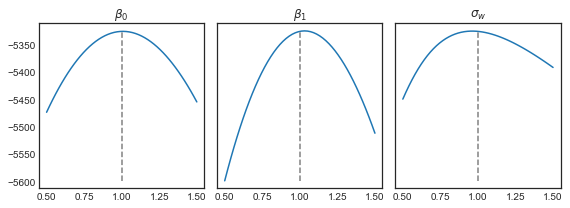

In [58]:
# a. Calculate log-likelihood profiles one by one
theta_v = np.linspace(0.5,1.5,50)

def ll_theta(log_likelihood, mp, theta_v, vname, x, y):
    ll = np.empty(len(theta_v))
    theta = copy(mp.theta)
    for i,v in enumerate(theta_v):
        theta[mp.theta_names == vname] = v  
        ll[i] = log_likelihood(theta, x, y, mp)
    return ll

b0_ll = ll_theta(log_likelihood, mp, theta_v, 'beta_0', x_obs, y_obs)
b1_ll = ll_theta(log_likelihood, mp, theta_v, 'beta_1', x_obs, y_obs)
sigma_ll = ll_theta(log_likelihood, mp, theta_v, 'sigma_w', x_obs, y_obs)

# b. Plot profiles 
xmin = np.min(np.concatenate((b0_ll,b1_ll,sigma_ll)))*(1.0)
xmax = np.max(np.concatenate((b0_ll,b1_ll,sigma_ll)))*(1)

plt.style.use('seaborn-white')
fig, axs = plt.subplots(1, 3, figsize=(8, 3), sharey=True)
axs[0].plot(theta_v, b0_ll)
axs[0].vlines(1.0, xmin, xmax, 'grey', '--')
axs[0].set_title('$\\beta_0$')

axs[1].plot(theta_v, b1_ll)
axs[1].set_title('$\\beta_1$')
axs[1].vlines(1.0, xmin, xmax, 'grey', '--')

axs[2].plot(theta_v, sigma_ll)
axs[2].set_title('$\\sigma_w$')
axs[2].vlines(1.0, xmin, xmax, 'grey', '--')
fig.tight_layout();

As you may notice, the likelihood function does not peak at the exact true parameters. This is a product of the small sample size and improves when increasing and `mp.N`. This results in estimated parameters that are off the true data generating values. 

**QUESTION 3**  
Estimate $\beta^0,\beta^1,\sigma_w$ by maximizing the log-likelihood function.  
You can use the BFGS method in `scipy` with numerical derivatives or Nelder-Mead.  
Use the starting values `theta0 = [0.8, 1.2, 0.7]`.  
If the optimization takes too long on your computer, then reduce $N,N^d$ to smaller numbers.

In [59]:
# a. Objective function 
def obj_func(theta): return -log_likelihood(theta, x_obs, y_obs, mp)

# b. Estimation using a derivative free method
theta_guess = np.array([0.8, 1.2, 0.7])
res = optimize.minimize(obj_func, theta_guess, method="Nelder-Mead")
print(res)

 final_simplex: (array([[1.03370507, 1.06860338, 1.06142926],
       [1.03371465, 1.06864115, 1.06149906],
       [1.03372334, 1.06862551, 1.06148451],
       [1.03368527, 1.06858116, 1.06141303]]), array([5324.65526616, 5324.65526623, 5324.65526631, 5324.65526632]))
           fun: 5324.655266156336
       message: 'Optimization terminated successfully.'
          nfev: 123
           nit: 67
        status: 0
       success: True
             x: array([1.03370507, 1.06860338, 1.06142926])


# B. Equilibrium on social media platforms

In this exercise you will find the equilibrium distribution of people on online social media platforms using a fixed point iteration procedure. 

The general idea is the following:  

There are 3 different social media platforms: _facebook, Instagram, TikTok_ and 2 kinds of users: _young_, _old_.  
**Young** users make up a fraction $\rho^{y}$ of the total population and **old** users make up the fraction $\rho^{o} = 1-\rho^{y}$. 

Each user type derives utility from being on a given platform through **3 channels**: 
   1. A type specific **valuation** of the platform, $w$.   
      This captures how much one likes the interface, features, etc.
   2. The **share** of the population who is on the platform, denoted $s$.   
      This is a network effect, capturing that more users makes a network more interesting.
   3. A stochastic taste shock, $\varepsilon$. This follows an Extreme Value type I distribution.   

Taken together, the **non-stochastic** utility a type $t \in \{y,o\}$ gets from being on media platform $m \in \{facebook, \: Instagram, \: TikTok\}$ is defined by
$$
u_{t,m} = w_{t,m} + s_{m}
$$
and total utility is given by 
$$
V_{t,m} = u_{t,m} + \varepsilon_{t,m}
$$
**OBJECTIVE**  
The objective is to compute the _equilibrium shares_ of young users and old users being active on each of the social media platforms.  
This gets complicated because the utility from using a platform is dependent on the choices of other users. 

**CHOICE PROBABILITIES**   
To make things simple, we assume that users are only active on one of the social media platforms and everyone chooses a platform.  

The fact that $\varepsilon_{t,p}$ follows an EV I distribution (also called Gumbel) means that the **probability** of choosing each social media platform is related to the non-stochastic utility from that choice through the convenient logit form:
$$
P_{t,m} = \frac{\exp(u_{t,m})}{{\sum_{l=1}^3 \exp(u_{t,l})}}
$$

Therefore the **total share** of users on a platform, e.g. TikTok, can be written as 
$$
s_{TikTok} = \rho^{y} \times P_{y,TikTok} + \rho^{o} \times P_{o,TikTok}
$$

**SOLUTION METHOD**    
One way to find the equilibrium distribution of users on platforms is to rely on what is called succesive approximations (or fixed point iterations).  

Recall that an equilibrium means that _no agent has an incentive to alter behavior_. In our context, this notion implies the following: 
1. Assume we have the **equilibrium** vector of user shares $s^*=$ [$s_1,s_2,s_3$] 
2. Then we can compute equilibrium utilities $u^*_{t,m}$ for each type and platform.
3. Using $u^*_{t,m}$, we can compute equilibrium choice probalities $P^*_{t,m}$.
4. Aggregating $P^*_{t,m}$ for each platform over types will deliver **the same** $s^*$ as in bullit point 1.

This is called a fixed point of the model. 

**Only problem:** We do not know $s^*$ up front!  
**Solution to problem:** Succesive approximations. Given some starting vector $s_0$, we can keep iterating on the problem using the ideas above until $s_k$ stops changing.   

**Succesive approximation algorithm**  
1. Define an initial guess of $s^0 = [s_1^0,s_2^0,s_3^0]$,  
   set a convergence criterion $\epsilon>0$,  
   set a counter $k=0$ and a maximum number of iterations $N$.
2. Compute $u_{t,m}^k$ for $\forall t,m$ based on $s^k$.
3. Compute $P^k_{t,m}$ for $\forall t,m$ based on $u_{t,m}^k$.
4. Compute the vector $s^{k+1}$ using all $P^k_{t,m}$ and population shares [$\rho^y,\rho^0]$.
5. Compute $u_{t,m}^{k+1}$ for $\forall t,m$ using $s^{k+1}$.
6. If $\text{max}_{t,m}|u_{t,m}^{k+1}-u_{t,m}^{k}| < \epsilon$ or $k>N$ then stop.  
   Otherwise:  
   set $k = k + 1$ and repeat from step 3. 

In [60]:
# Parameters
mp = SimpleNamespace()
mp.platforms = ['facebook', 'instagram', 'tiktok']  # Order of platforms
mp.rho_y = 0.6                                     # Share of young users
mp.rho_o = 1.0-mp.rho_y                            # Share of old users
mp.w_y = np.array([0.7, 1.5, 1.8])                 # Valuations by young users
mp.w_o = np.array([0.9, 0.2, 0.01])                # Valuations by old users
mp.eps = 1e-8                                      # Convergence criterion
mp.N = 100                                         # Max number of iterations
s0 = np.array([0.9, 0.05, 0.05])                   # Initial guess on shares


**QUESTION 1**  
Find the equilibrium distribution of users on social media platforms using succesive approximation method above and the parameters in `mp`. 

In [61]:
# a. See question2.py for implementation of algorithm
from question2 import * 
mp.utility_spec = 'baseline'

# b. Compute equilibrium distribution
s_total,s_age,util = some_eq(mp, s0)

print("Aggregated distribution of users,%")
for i in range(3):
    print(f'{mp.platforms[i]:<12} {s_total[i]*100:<5.1f}')

print("\nDistibution of young and old users,%")
print(f'{" ":<12} {"Young":>4}  {"Old":>4}')
for i in range(3):
    print(f'{mp.platforms[i]:<12} {s_age[0,i]*100:<5.1f} {s_age[1,i]*100:<5.1f}')


Aggregated distribution of users,%
facebook     29.6 
instagram    30.9 
tiktok       39.6 

Distibution of young and old users,%
             Young   Old
facebook     15.2  51.1 
instagram    34.3  25.7 
tiktok       50.5  23.2 


*Notice how a lot of old users end up being on tiktok and instagram even though they much prefer facebook when disregarding network effects.* 

Now we change the preferences of young users by letting their utility be **negatively** affected by the share of old users on a platform.  
Thus, the utility of young users is given by 
$$
u^y_{t,m} = w_{t,m} + s_{m}^{y} - s_{m}^o
$$ 
where 
$$
s_{m}^t = \rho^{t} \times P_{t,m}
$$
while the utility of old users is the same as before.

**QUESTION 2**  
Find the new equilibrium distribution of users on the platforms now that young users do not like hanging out with the old. Comment on the result. 

In [62]:
# a. See question2.py for implementation of algorithm
from question2 import * 
mp.utility_spec = 'negative_externality'

# b. Compute equilibrium distribution
s_total,s_age,util = some_eq(mp, s0)

print("Aggregated distribution of users when young people experience negative utility from old people,%")
for i in range(3):
    print(f'{mp.platforms[i]:<12} {s_total[i]*100:<5.1f}')

print("\nDistibution of young and old users when young people experience negative utility from old people,%")
print(f'{" ":<12} {"Young":>4}  {"Old":>4}')
for i in range(3):
    print(f'{mp.platforms[i]:<12} {s_age[0,i]*100:<5.1f}  {s_age[1,i]*100:<5.1f}')

Aggregated distribution of users when young people experience negative utility from old people,%
facebook     27.6 
instagram    31.3 
tiktok       41.2 

Distibution of young and old users when young people experience negative utility from old people,%
             Young   Old
facebook     12.4   50.4 
instagram    34.8   25.9 
tiktok       52.8   23.7 


*Interestingly, this does not push the distribution very much. Young people may opt towards tiktok, which is the least preferred option for the old. But more users on tiktok in general raises the value of tiktok for the old as well which makes them follow along.* 

## Question 3 - A convergence safe hybrid rootfinder.

We will now consider a rootfinding algorithm that synthezises the bisection method (B) and Newton-Raphson (NR).  

Each algorithm has its pros and cons. Bisection has ensured convergence, yet it might require many steps before that happens. The Newton-Raphson will normally converge in much fewer steps, but there is a chance that it will instead diverge if the domain of the function is bounded and thus never find the root.   

The hybrid algorithm combines the two methods to make sure that convergence is guaranteed at a faster rate than bisection can deliver alone. 

We are considering a function $f$ that lives on a bounded domain $[a,b]$.  
The idea is to primarily take a Newton step as default, but then use bisection if this step jumps out of bounds of the function domain. 

Recall that **Newton-Raphson** will find the root, $x^*$, of a function $f(x)$ by taking iterative steps on the form:
$$
x_{k+1} = x_{k} - \frac{f(x_{k})}{f^{\prime}(x_{k})} \equiv \mathcal{N}(x_k) 
$$

The **Bisection** method instead takes the midpoint on the interval that the root must reside on and assigns $x_{k+1}$ to that. We can write a bisection step as:
$$
x_{k+1} = a_k + \frac{b_k-a_k}{2} \equiv \mathcal{B}(a_{k}, b_{k}) \\
$$ 

In addition, the bisection algorithm must update the upper and lower bound on the interval on which the root must lie. It does so by eliminating the half part of the current interval which does **not** include the new midpoint. 
$$
\begin{align*}
\mathcal{C}: \textbf{if} \:\: f(a_k) \times f(x_{k+1}) < 0 \:\: & \textbf{then}  \:\: & b_{k+1} = x_{k+1}, \:\: a_{k+1} = a_{k} \\  
& \textbf{else}  \:\: & a_{k+1} = x_{k+1}, \:\: b_{k+1} = b_{k}
\end{align*}
$$

**Note:** we can safely apply this elimation of the half-interval at **each iteration**, not just when using bisection, since we know that the discarded half will not contain the root.  




**Algorithm: `safe_NR`**
1. Provide the following parameters: 
   * $\epsilon > 0$ (the convergence criterion)
   * $x_0$ (the initial **guess** on $x^*$). 
   * [$a_0$, $b_0$] (the interval on which $x^*$ should reside).
   * set $k=0$. 
2. Compute $x_1 = \mathcal{N}(x_0)$
3. If $x_1 \notin [a_0, b_0]$ use $x_1 = \mathcal{B}(x_0)$
4. Update the bounds $a_0$ and $b_0$ according to condition $\mathcal{C}$
5. If $|f(x_1)|<\epsilon$ then stop.  
   Otherwise, set $k=k+1$ and reiterate from point 2.  




In [63]:
# Parameters
f = lambda x: np.arctan(x)      # function f
fprime = lambda x : 1/(1+x**2)  # derivative of f
a = -4.0                        # lower bound on domain
b = 4.0                         # upper bound on domain
x0 = 1.5                        # initial guess on root

**Excercises**  
1. Plot the function $\arctan(x)$ on the domain $[a,b]$ which is specified above.  
   Comment on what the problem with a pure Newton-Raphson method might be in this instance. 

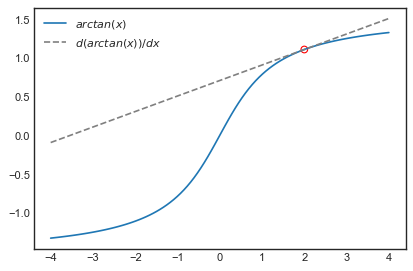

In [64]:
# a. calculate arctan(x) on range
xs = np.linspace(a,b,100)
fxs = f(xs)
fpxs = fprime(xs)

# b. Calculate slope of arctan at 2.0
x0  = 2.0
fpxs = f(x0) + fprime(x0)*(xs - x0)

# c. Plot 
fig = plt.figure(dpi=(80))
ax = fig.add_subplot(1,1,1)
ax.plot(xs,fxs,label='$arctan(x)$')
ax.plot(xs, fpxs, '--', label="$d(arctan(x))/dx$",color='grey')
ax.legend()
ax.scatter(x0,f(x0), facecolors='none', edgecolors='r');


Notice here, that if we used $x_0=2.0$ as initial guess, then Newton-Raphson produces a next guess of the root that is far out of the domain of $x$ on which we (pretend to) know `arctan(x)`. We therefore need the bisection step to obtain a guess within the domain $[-4,4]$ where we can actually compute `arctan(x)`.

2. Implement `safe_NR` in code and find $x^*$ when using $x_0=1.5$ as initial guess.

In [65]:
# See question3.py for implementation
from question3 import safe_NR 

x_star,j = safe_NR(f, fprime, a, b, x0, maxit=20, tol=1e-14)
print(f'root of arctan(x) = {x_star:1.3f}')

root of arctan(x) = -0.000
